# Multiple Regression from Simple Univariate Regression

Suppose we have a univariate model with no intercept:

$$Y = X\beta + \epsilon$$

The least squares estimate and residuals are:

$$\begin{aligned}
\hat\beta &= \frac{\sum_1^N x_i y_i}{\sum_1^N x^2_i}\\
r_i &= y_i - x_i\hat\beta
\end{aligned}$$

In vector notation, $\mathbf{y} = [y_1, y_2, \cdots, y_N]^\top$, $\mathbf{x} = [x_1, x_2, \cdots, x_N]^\top$, and let's define:

$$\langle\mathbf{x}, \mathbf{y}\rangle =\sum_1^N x_i y_i =\mathbf{x}^\top\mathbf{y}$$

then we can write:
$$\begin{aligned}
\hat\beta &= \frac{\langle\mathbf{x}, \mathbf{y}\rangle}{\langle\mathbf{x}, \mathbf{x}\rangle}
\end{aligned}$$


### Regression by Successive Orthogonalization
We can see that the univariate regression provides the building block for multiple linear regression.

Suppose that the columns of the inputs $\mathbf X = [\mathbf x_1, \mathbf x_2, \cdots, \mathbf x_p$ are orthogonal ($\langle\mathbf{x_j}, \mathbf{x_k}\rangle = 0$, for $j\neq k$):

$$\hat\beta_j = \frac{\langle\mathbf{x_j}, \mathbf{y}\rangle}{\langle\mathbf{x_j}, \mathbf{x_j}\rangle}$$

In real-world scenarios, it's very unlikely that we have orthogonal inputs. Therefore, to  use this result, we need to first orthogonalize the inputs.

Assume we have an intercept and a single input $\mathbf x$, then the least squares coefficient of $\mathbf x$ has the form

$$\hat\beta_1 = \frac{\langle \mathbf x - \bar x\mathbf 1, \mathbf y\rangle}{\langle \mathbf x - \bar x\mathbf 1, \mathbf x - \bar x\mathbf 1\rangle}$$

where $\bar x = \sum_i x_i /N$, and $\mathbf 1 = \mathbf x_0$, the vector of $N$ ones. 

The estimate given above can be viewed as the result of two simple regression:

   * regress $\mathbf x$ on $\mathbf 1$ to produce the residual $\mathbf z = \mathbf x - \bar x \mathbf 1$
   * regress $\mathbf y$ on the residual $\mathbf z$ to give the coefficient $\hat\beta_1$
   
This result generalizes to the case of $p$ inputs, as shown in the following algorithm:

##### Algorithm 3.1
   1. Initialize $\mathbf z_0 = \mathbf x_0 = \mathbf 1$
   2. For $j=1,2,\cdots, p$
       Regress $\mathbf x_j$ on $\mathbf z_0, \mathbf z_1, \cdots, \mathbf z_{j-1}$ to produce coefficients 
       $$\hat\gamma_{lj} = \langle\mathbf z_l\mathbf x_j\rangle / \langle \mathbf z_l, \mathbf z_l\rangle$$
       for $l=0, 1, \cdots, j -1$, and residual vector:
       $$\mathbf z_j = \mathbf x_j - \sum_{k = 0}^{j-1} \hat\gamma_{kj} \mathbf z_k$$
   3. Regress $\mathbf y$ on the residual $\mathbf z_p$ to give the estimate $\hat\beta_p$
   
The result of this algorithm is

$$\hat\beta_p = \frac{\langle \mathbf z_p, \mathbf y\rangle}{\langle \mathbf z_p, \mathbf x_p\rangle}$$

#### Python Implementation

In this section, we implement Algorithm 3.1 in python. We use *Prostate Cancer* data to test the algorithm.

##### Data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from ml_datasets.esl import ProstateCancer
from esl.chapter03 import LeastSquaresRegression
from esl.utils import scale

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

In [4]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

##### Scaling

In [5]:
df_x = df_x.apply(lambda x: scale(x))

In [6]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values

##### Main Algorithm

Here, we develop a class for least squares regression by orthogonalization. This class contains several methods:

   * `fit`: to fit the model using the orthogonalization least squares algorithm. It calls `compute_gamma` and `compute_beta_hat_z` methods. It gives us both $\hat\beta$ in the $x$ and $z$ domains.
   * `compute_gamma`: it implements step 2 in algorithm 3.1. **Note**: we start from $0$ instead of $1$ so that we can compute the diagonal elements of $\hat\gamma$.
   * `compute_beta_hat_z`: it implements step 3 in algorithm 3.1. **Note**: the computed $\hat\beta_z$ is for the orthogonalized input $Z$. Therefore, to predict we need to multiply $\mathbf Z$ by this $\hat\beta$. 
   $$\mathbf Y = \mathbf Z \hat\beta_z$$
   
   To work in the original $X$ space, where $\mathbf X = \mathbf Z \Gamma$, we need to transform $\hat\beta_z$ first:
   
   $$\begin{aligned}
   \mathbf Y &= \mathbf Z \hat\beta_z\\
   &= \mathbf X \underbrace{\Gamma^{-1} \hat\beta_z}_{\hat\beta_x}
   \end{aligned}$$
   
   where $\Gamma^{-1} \hat\beta_z$ is the new $\hat\beta_x$ in the $X$ space.
   * `predict`: do prediction using (can be in either $X$ or $Z$ domains)

In [7]:
class LSOrthogonalization(LeastSquaresRegression):
    def __init__(self, *args, **kwargs):
        
        super(LSOrthogonalization, self).__init__(*args, **kwargs)
        
    def fit(self, x, y):
        x = self._check_intercept(x)

        self.compute_gamma(x)
        
        self.compute_beta_hat_z(y)

        self.beta_hat_x = np.linalg.inv(self.gamma) @ self.beta_hat_z
    
    def compute_beta_hat_z(self, y):
        self.beta_hat_z = np.zeros(self.z.shape[1])
        
        for i in range(self.z.shape[1]):
            self.beta_hat_z[i] = (self.z[:, i] @ y) / (self.z[:, i] @ self.z[:, i])
        
    def compute_gamma(self, x):
        self.z = np.zeros_like(x)
        self.z[:, 0] = 1.0
        self.gamma = np.zeros((x.shape[1], x.shape[1]))
        
        for i in range(x.shape[1]):
            sum_gamma_z = 0
            
            for j in range(i):
                self.gamma[j, i] = (self.z[:, j] @ x[:, i]) / (self.z[:, j] @ self.z[:, j])
                sum_gamma_z = sum_gamma_z + (self.gamma[j, i] * self.z[:, j])

            self.z[:, i] = x[:, i] - sum_gamma_z
            self.gamma[i, i] = (self.z[:, i] @ x[:, i]) / (self.z[:, i] @ self.z[:, i])
            
        
    def predict(self, x, mode='x'):
        x = self._check_intercept(x)

        if mode == 'x':
            return x @ self.beta_hat_x
        
        elif mode == 'z':
            return x @ np.linalg.inv(self.gamma) @ self.beta_hat_z

Here, we initialize the class and fit the data:

In [8]:
lsortho  = LSOrthogonalization()
lsortho.fit(x_train, y_train)

Do prediction in both $X$ and $Z$ domains for comparison:

In [9]:
y_hat_x = lsortho.predict(x_train, mode='x')
y_hat_z = lsortho.predict(x_train, mode='z')

Plot the predictions results

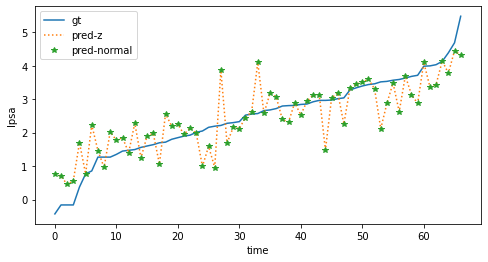

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(y_train, label='gt')
plt.plot(y_hat_z, ':', label='pred-z')
plt.plot(y_hat_x, '*', label='pred-normal')
plt.xlabel('time')
plt.ylabel('lpsa')
plt.legend()
plt.show()

### Regression by QR Decomposition

Step 2 of Algorithm 3.1 can be represented in matrix form:

$$\mathbf X = \mathbf Z \mathbf\Gamma$$

where $\mathbf Z$ has as columns the $\mathbf z_j$, and $\mathbf\Gamma$ is the upper triangular matrix with entries $\hat\gamma_{kj}$.

Introducing the diagonal matrix $\mathbf D$ with $jth$ diagonal element $D_{jj} = \|\mathbf z_j\|$, we obtain

$$\begin{aligned}\mathbf X &= \mathbf Z \mathbf D^{-1}\mathbf D\mathbf\Gamma\\
&= \mathbf Q\mathbf R
\end{aligned}$$

the so-called **QR** decomposition of $\mathbf X$.

The least squares solution is given by:

$$
\begin{aligned}
\hat\beta &= \mathbf R^{-1} \mathbf Q^\top \mathbf y\\
\hat{\mathbf y} & = \mathbf Q\mathbf Q^\top \mathbf y
\end{aligned}
$$

#### Python Implementation
We use the same dataset in the previous section so we can compare the performance of both the algorithms.

##### Main Algorithm
Here, we develop a class for least squares regression by **QR** decomposition. This class extends `LSOrthogonalization` class and contains several methods:

   * `fit`: it's used to fit the model using the **QR** least squares algorithm. It calls `compute_gamma` (from `LSOrthogonalization`) and `compute_QR` methods. It gives us both $\hat\beta$ that is computed using:
   
   $$\hat\beta = \mathbf R^{-1} \mathbf Q^\top \mathbf y$$
   
   * `compute_QR`: it calculates the $\mathbf Q$ and $\mathbf R$ matrices by introducing the diagonal matrix $\mathbf D$.
   
   * `predict`: it calculates the prediction using:
   
   $$ \hat\beta = \mathbf X\hat\beta$$

In [11]:
class LSQR(LSOrthogonalization): 
    def __init__(self, *args, **kwargs):
        super(LSQR, self).__init__(*args, **kwargs)
        
    def fit(self, x, y):
        x = self._check_intercept(x)
        self.compute_gamma(x)
        self.compute_QR()
        self.beta_hat = np.linalg.inv(self.R) @ self.Q.T @ y
            
    def compute_QR(self):
        D = np.diag(np.linalg.norm(self.z, axis=0))
        
        self.Q = self.z @ np.linalg.inv(D)
        self.R = D @ self.gamma
        
    def predict(self, x):
        x = self._check_intercept(x)
        return x @ self.beta_hat

Initialize the class and fit the data.

In [12]:
lsqr = LSQR()
lsqr.fit(x_train, y_train)

Do prediction

In [13]:
y_hat_qr = lsqr.predict(x_train)

#### Comparison: LS-Orthogonalization VS LS-QR-Decomposition

First, we compare the parameters $\hat\beta$ between the two algorithms:

In [14]:
print("LS-Orthogonalization Beta: ", lsortho.beta_hat_x)
print("LS-QR-Decomposition Beta: ", lsqr.beta_hat)

LS-Orthogonalization Beta:  [ 2.46493292  0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332
 -0.28700184 -0.02119493  0.26557614]
LS-QR-Decomposition Beta:  [ 2.46493292  0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332
 -0.28700184 -0.02119493  0.26557614]


We can see that they are identicals.

Now, we plot the test prediction of both algorithms:

In [15]:
x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values
y_test_hat_ortho = lsortho.predict(x_test)
y_test_hat_qr = lsqr.predict(x_test)

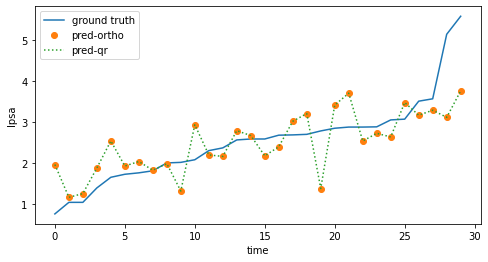

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='ground truth')
plt.plot(y_test_hat_ortho, 'o', label='pred-ortho')
plt.plot(y_test_hat_qr, ':', label='pred-qr')
plt.legend()
plt.xlabel('time')
plt.ylabel('lpsa')
plt.show()

#### Sanity Check

Just to make sure that our implementations of the algorithms are correct, we compare them with the Least Squares algorithm using Normal equation developed in the previous section:

In [17]:
lsreg = LeastSquaresRegression()
lsreg.fit(x_train, y_train)

In [18]:
print("LS-Orthogonalization Beta: \n {}".format(lsortho.beta_hat_x))
print("LS-QR-Decomposition Beta: \n {}".format(lsqr.beta_hat))
print("LS-Normal Beta: \n {}".format(lsreg.beta_hat))

LS-Orthogonalization Beta: 
 [ 2.46493292  0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332
 -0.28700184 -0.02119493  0.26557614]
LS-QR-Decomposition Beta: 
 [ 2.46493292  0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332
 -0.28700184 -0.02119493  0.26557614]
LS-Normal Beta: 
 [ 2.46493292  0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332
 -0.28700184 -0.02119493  0.26557614]


We can see that they have identical coefficients.